In [1]:
import numpy as np
from functions import *
import scipy as sp
from qibo import hamiltonians
import matplotlib.pyplot as plt
from tqdm import tqdm
import qibo
from qibo.symbols import *

In [36]:

def matrixPolynomialEvolutionDBI(initState, H, coeffs, method = "DBI", rootSelection = False):

    steps = len(coeffs)
    state = initState.copy()
    coeffs2 = coeffs.copy()
    energy = np.zeros(steps)

    for i in range(steps):

        # pick the coefficient such that np.abs(E-coeff) is maximized
        if rootSelection:
            coeff = coeffs2[np.argmax(np.abs(coeffs2 - energy))]
            coeffs2 = np.delete(coeffs2, np.argmax(np.abs(coeffs2 - energy)))
        else:
            coeff = coeffs[i]

        s, theta = matrixPolynomialScheduling(state, H, coeff)
        rho = np.outer(state, state.conj())
        W = commutator(rho, H)

        t = np.sign(s)*np.sqrt(np.abs(s))

        if method == "DBI":
            state = sp.linalg.expm(1j*theta*rho) @ sp.linalg.expm(s*W) @ state
        elif method == "DBQITE":
            state = sp.linalg.expm(-1j*theta*rho) @ sp.linalg.expm(1j*t*H) @ sp.linalg.expm(1j*t*rho) @ sp.linalg.expm(-1j*t*H) @ state
        elif method == "DBQITE3":
            phi = (1+np.sqrt(5)/2)
            ref1 = sp.linalg.expm(1j*phi*t*rho)
            ref2 = sp.linalg.expm(-1j*(phi+1)*t*rho)
            U = sp.linalg.expm(-1j*theta*rho) @ sp.linalg.expm(1j*phi*t*H) @ ref1 @ sp.linalg.expm(-1j*t*H) @ ref2 @ sp.linalg.expm(1j*(1-phi)*t*H)
            state = U @ state

        energy[i] = np.real(np.vdot(state, H @ state)) 
        
    state = state / np.linalg.norm(state)
    return state, energy

[Qibo 0.2.16|WARNING|2025-06-02 10:54:36]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


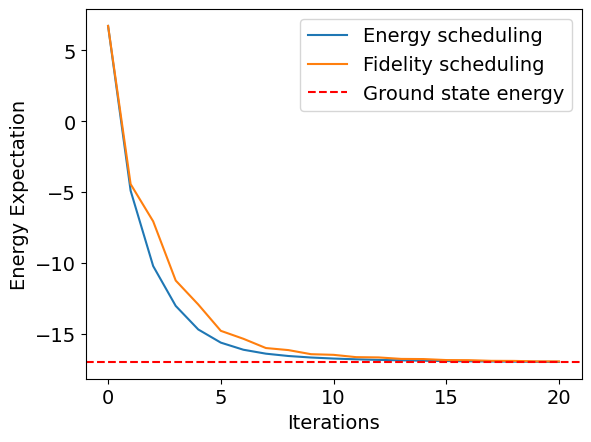

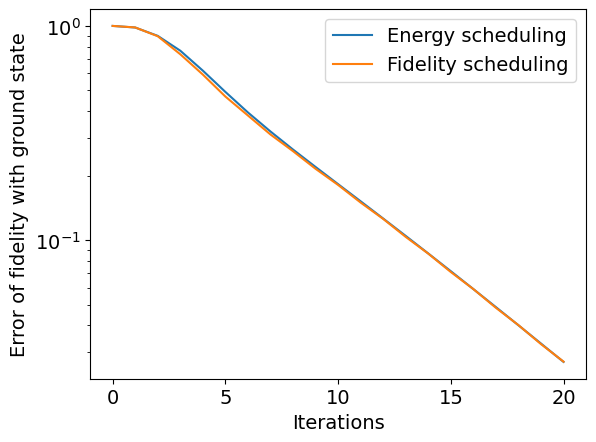

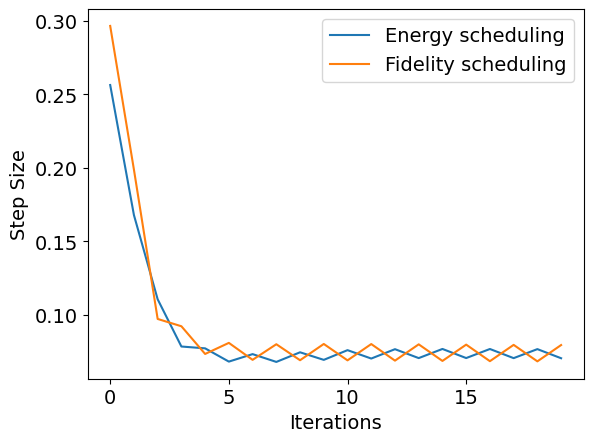

In [35]:
np.random.seed(42) 
plt.rcParams.update({'font.size': 14})
nqubits = 10
H_def = sum([X(x)*X(x+1)+Y(x)*Y(x+1)+Z(x)*Z(x+1)  for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
eigenvalues, eigenvectors = np.linalg.eigh(H)
E0 = eigenvalues[0]
gs = eigenvectors[:, np.argmin(eigenvalues)]
iters = 20
initState = np.random.rand(2**nqubits) + 1j * np.random.rand(2**nqubits)
initState /= np.linalg.norm(initState)

fidelityE, _ , stepsE, energyE = optimalDBI(H, initState, gs, "DBI", "Energy", iters)
fidelityF, _ , stepsF, energyF = optimalDBI(H, initState, gs, "DBI", "Fidelity", iters)


plt.figure()
plt.plot(energyE, label="Energy scheduling")
plt.plot(energyF, label="Fidelity scheduling")
plt.axhline(E0, color='red', linestyle='--', label="Ground state energy")
plt.xlabel("Iterations")
plt.ylabel("Energy Expectation")
plt.legend()

plt.figure()
plt.plot(1-fidelityF, label="Energy scheduling")
plt.plot(1-fidelityE, label="Fidelity scheduling")
plt.xlabel("Iterations")
plt.ylabel("Error of fidelity with ground state")
plt.yscale("log")
plt.legend()

plt.figure()
plt.plot(stepsE, label="Energy scheduling")
plt.plot(stepsF, label="Fidelity scheduling")
plt.xlabel("Iterations")
plt.ylabel("Step Size")
plt.legend()


[Qibo 0.2.16|WARNING|2025-06-03 11:29:46]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


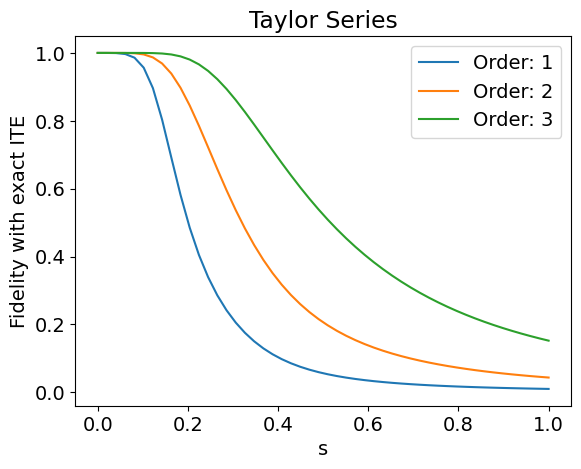

In [49]:
np.random.seed(42) 
plt.rcParams.update({'font.size': 14})
nqubits = 8
H_def = sum([X(x)*X(x+1)+Y(x)*Y(x+1)+Z(x)*Z(x+1)  for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
initState = np.random.rand(2**nqubits)
initState = initState / np.linalg.norm(initState)

s = np.linspace(0, 1, 50)
order = [1, 2, 3]
plt.figure()
plt.title("Taylor Series")
for i in range(len(order)):
    fidelityDBITaylor = np.zeros(len(s))

    fidelityITE = np.zeros(len(s))
    
    for j in range(len(s)):
        state = sp.linalg.expm(-s[j]*H) @ initState
        state /= np.linalg.norm(state)
        fidelityITE[j] = Fidelity(state, initState)
        coeffs = findRoots(order[i], -s[j])
        stateDBI, _ = matrixPolynomialEvolutionDBI(initState, H, coeffs, method = "DBI")
        fidelityDBITaylor[j] = Fidelity(stateDBI, state)
        

    plt.plot(s, fidelityDBITaylor, label=f"Order: {order[i]}")
plt.xlabel("s")
plt.ylabel("Fidelity with exact ITE")
plt.legend()



[Qibo 0.2.16|WARNING|2025-06-03 11:58:33]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


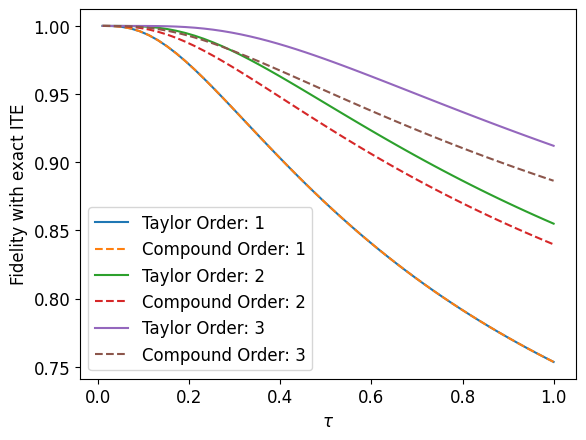

In [79]:
np.random.seed(0) 
plt.rcParams.update({'font.size': 12})
nqubits = 8
H_def = sum([X(x)*X(x+1)-Z(x+1)  for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
initState = np.zeros(2**nqubits)
initState[0] = 1.0

s = np.linspace(0.01, 1, 50)
order = [1, 2, 3]
plt.figure()
for i in range(len(order)):
    fidelityDBITaylor = np.zeros(len(s))
    fidelityDBICompound = np.zeros(len(s))

    for j in range(len(s)):
        state = sp.linalg.expm(-s[j]*H) @ initState
        state /= np.linalg.norm(state)
        coeffs = np.ones(order[i]) * (order[i]/s[j])
        stateDBI, _ = matrixPolynomialEvolutionDBI(initState, H, coeffs, method = "DBI")
        fidelityDBICompound[j] = Fidelity(stateDBI, state)
        coeffs = findRoots(order[i], -s[j])
        stateDBI, _ = matrixPolynomialEvolutionDBI(initState, H, coeffs, method = "DBI")
        fidelityDBITaylor[j] = Fidelity(stateDBI, state)
        
    plt.plot(s, fidelityDBITaylor, label=f"Taylor Order: {order[i]}")
    plt.plot(s, fidelityDBICompound, '--', label=f"Compound Order: {order[i]}")
plt.xlabel(r"$\tau$")
plt.ylabel("Fidelity with exact ITE")
plt.legend()



[Qibo 0.2.16|WARNING|2025-06-03 14:12:06]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0.7198137300598981


c:\Users\andre\Desktop\EPFL\Master-Project\Master-Project\functions.py:214: ComplexWarning: Casting complex values to real discards the imaginary part
  steps[i] = s


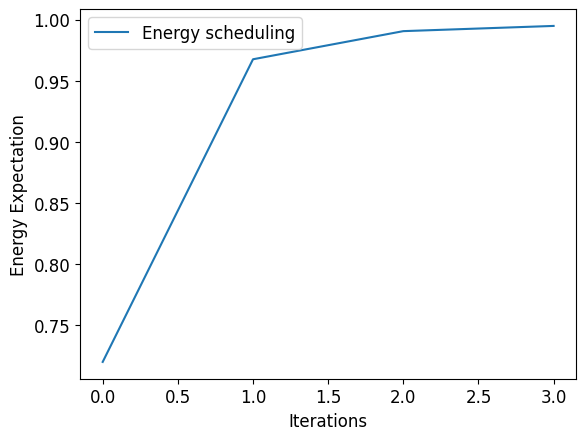

<Figure size 640x480 with 0 Axes>

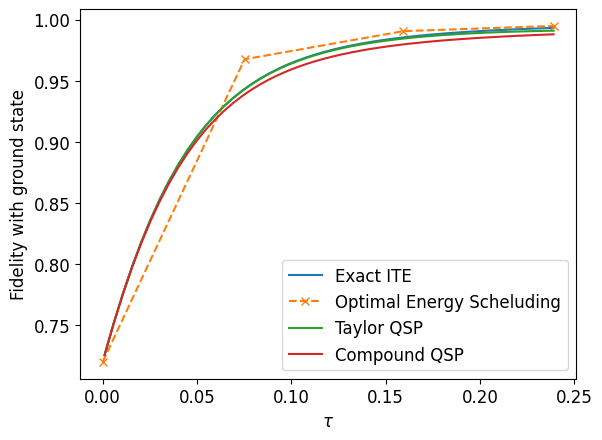

In [155]:
plt.rcParams.update({'font.size': 12})
nqubits = 8
H_def = sum([X(x)*X(x+1)-Z(x+1)  for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
eigenvalues, eigenvectors = np.linalg.eigh(H)
E0 = eigenvalues[0]
gs = eigenvectors[:, np.argmin(eigenvalues)]
iters = 3
initState = 1.5*gs + 0.1*np.random.rand(2**nqubits)
initState /= np.linalg.norm(initState)
print(Fidelity(initState, gs))


fidelityE, _ , stepsE, energyE = optimalDBI(H, initState, gs, "DBI", "Energy", iters)
fidelityF, _ , stepsF, energyF = optimalDBI(H, initState, gs, "DBI", "Fidelity", iters)

plt.figure()
plt.plot(fidelityE, label="Energy scheduling")
plt.xlabel("Iterations")
plt.ylabel("Energy Expectation")
plt.legend()

newSteps = np.zeros(len(stepsE)+1)
newSteps[0] = 0
for i in range(1,len(stepsE)+1):
    newSteps[i] = newSteps[i-1]+stepsE[i-1]

s = np.linspace(0.001, newSteps[-1], 50)
fidelityITE = np.zeros(len(s))
fidelityDBITaylor = np.zeros(len(s))
fidelityDBICompound = np.zeros(len(s))

for i in range(len(s)):
    state = sp.linalg.expm(-s[i]*H) @ initState
    state /= np.linalg.norm(state)
    fidelityITE[i] = Fidelity(state, gs)

    state = sp.linalg.expm(-s[i]*H) @ initState
    state /= np.linalg.norm(state)
    coeffs = np.ones(iters) * (iters/s[i])
    stateDBI, _ = matrixPolynomialEvolutionDBI(initState, H, coeffs, method = "DBI")
    fidelityDBICompound[i] = Fidelity(stateDBI, gs)
    coeffs = findRoots(iters, -s[i])
    stateDBI, _ = matrixPolynomialEvolutionDBI(initState, H, coeffs, method = "DBI")
    fidelityDBITaylor[i] = Fidelity(stateDBI, gs)

plt.figure()     



plt.figure()
plt.plot(s, fidelityITE, label="Exact ITE")
plt.plot(newSteps, fidelityE, "x--", label ='Optimal Energy Scheluding')
plt.plot(s, fidelityDBITaylor, label='Taylor QSP')
plt.plot(s, fidelityDBICompound, label='Compound QSP')
plt.xlabel(r"$\tau$")
plt.ylabel("Fidelity with ground state")
plt.legend()
